<a href="https://colab.research.google.com/github/StuartLiv/CPSC-440-Project/blob/main/v0/optim_experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from tqdm import tqdm
import re
from keras.preprocessing.image import img_to_array # TODO don't use keras
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random



# workflow notebook

Used reference:
-  [git in colab](https://www.geeksforgeeks.org/how-to-install-and-use-git-in-google-colab/)!

# 0. Open ipynb from github
To get this latest notebook from our repo into colab:
> "Open in colab" button == {Download from github} + {Upload to colab} - {Gets saved to drive}

# 1. Set up project in runtime
Copy the following cell and run it with your credentials to clone the repo, getting datasets as runtime files, and then delete your credentials.

In [ ]:
!git config --global user.email "<email>"
!git config --global user.name "<name>"
!git clone https://[token]@github.com/StuartLiv/CPSC-440-Project

In [ ]:
%pwd

'/content'

`git clone` seems too good to be true for getting a few GB of data into runtime, but `/datasets/` is up once clone is run! See:

In [ ]:
path = '/content/CPSC-440-Project/datasets/largeset_multisize/color'
files = os.listdir(path)
print(files)

['17733.jpg', '13602.jpg', '6156.jpg', '665.jpg', '11804.jpg', '13195.jpg', '5227.jpg', '5201.jpg', '12444.jpg', '11829.jpg', '16370.jpg', '7036.jpg', '7465.jpg', '7241.jpg', '16118.jpg', '17958.jpg', '18045.jpg', '2904.jpg', '11524.jpg', '8230.jpg', '7319.jpg', '2444.jpg', '16420.jpg', '6195.jpg', '3707.jpg', '4357.jpg', '9880.jpg', '9879.jpg', '10844.jpg', '17551.jpg', '15643.jpg', '1604.jpg', '16050.jpg', '1414.jpg', '11191.jpg', '17573.jpg', '458.jpg', '15874.jpg', '10260.jpg', '12762.jpg', '14126.jpg', '17927.jpg', '18136.jpg', '150.jpg', '5962.jpg', '6251.jpg', '3396.jpg', '6530.jpg', '9889.jpg', '10745.jpg', '17926.jpg', '8875.jpg', '15210.jpg', '12611.jpg', '14021.jpg', '4754.jpg', '13766.jpg', '15561.jpg', '3681.jpg', '16991.jpg', '12972.jpg', '6910.jpg', '5632.jpg', '16959.jpg', '6921.jpg', '13485.jpg', '11039.jpg', '13249.jpg', '8254.jpg', '14326.jpg', '8206.jpg', '12985.jpg', '17929.jpg', '17709.jpg', '16503.jpg', '3958.jpg', '193.jpg', '17290.jpg', '10478.jpg', '2611.jpg',

# 2. Preprocess data

Datasets:
- `smallset_onesize` [DEPRECATED - DO NOT USE]
  - Downloaded as is, [here](https://www.kaggle.com/datasets/theblackmamba31/landscape-image-colorization).
  - 7130 color/gray pairs
  - Res 150x150
  - 0.232GB
- `largeset_multisize` [USE THIS ONE]
  - Stored in Github repo, made from combination of other datasets. Dataset construction code in repo too
  - 18329 color/gray pairs. (actually 18328 - had to delete photo 2507 due to strange resolution issues)
  - Res 128x128 (grayscale images also available in 64x64, 32x32, 16x16)
  - 401 MB



In [ ]:


''' Returns an array containing all images in folder, sorted by filename. Useful for color/gray/downsize versions in different folders with same filename.
@param path - directory with images
@return
'''
def make_image_arr(path):

  def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)

  files = os.listdir(path)
  files = sorted_alphanumeric(files)

  arr = []
  for i in tqdm(files):
    img = cv.imread(path + '/'+i,1)
    img = img.astype('float32') / 255
    arr.append(img_to_array(img))

  return arr


In [ ]:
color_arr = make_image_arr('/content/CPSC-440-Project/datasets/largeset_multisize/color')

100%|██████████| 18328/18328 [00:09<00:00, 1896.20it/s]


In [ ]:
gray_arr = make_image_arr('/content/CPSC-440-Project/datasets/largeset_multisize/gray')

100%|██████████| 18328/18328 [00:07<00:00, 2365.39it/s]


17447


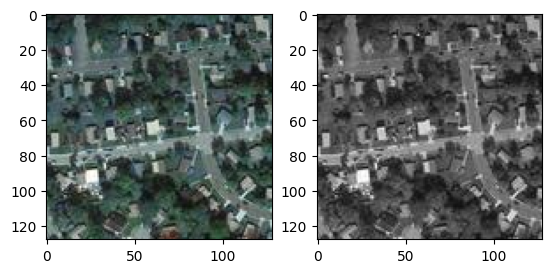

8149


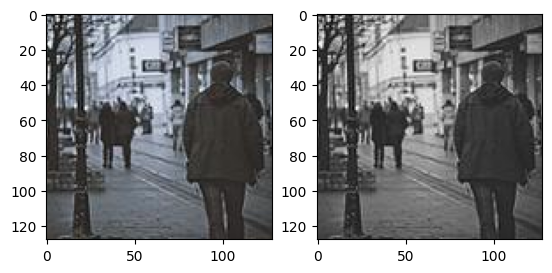

12960


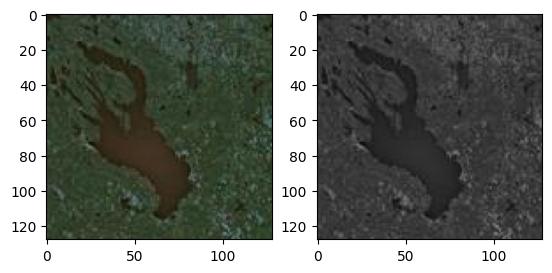

6779


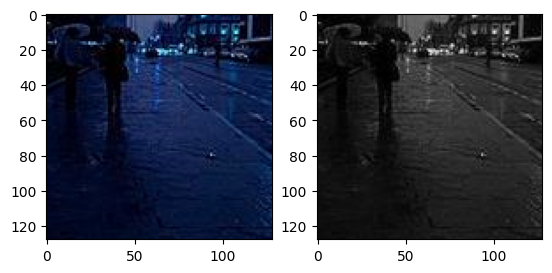

In [ ]:

for i in np.random.randint(len(color_arr),size=4):
  print(i)
  plt.subplot(1,2,1)
  plt.imshow(color_arr[i])
  plt.subplot(1,2,2)
  plt.imshow(gray_arr[i])
  plt.show()

In [ ]:
# Make a tensor list of reformatted images (based on Stuarts's axis swap)
gray_tensors = []

for image in gray_arr:
    # Convert each image to a PyTorch tensor
    t = torch.from_numpy(np.moveaxis(image, [2, 1], [0, 2]))
    gray_tensors.append(t)

color_tensors = []

for image in color_arr:
    # Convert each image to a PyTorch tensor
    t = torch.from_numpy(np.moveaxis(image, [2, 1], [0, 2]))
    color_tensors.append(t)

# 3. Model
Toy model generated below:

In [ ]:
# prompt: pytorch colourization autoencoder

class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 16, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Create the autoencoder
autoencoder = Autoencoder()



Train toy model:

In [ ]:
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

# Training loop
num_epochs = 3
for epoch in range(num_epochs):
    running_loss = 0.0
    for i in range(len(gray_arr)):
        if (gray_tensors[i].size() != torch.Size([3, 128, 128])):
          continue # turns out there are some non-square images (like maybe 5 or 10 total) in the original smallset dataset, and so they're here too... temporary fix

        inputs = gray_tensors[i].unsqueeze(0)  # Add batch dimension
        targets = color_tensors[i].unsqueeze(0)  # Add batch dimension

        optimizer.zero_grad()
        outputs = autoencoder(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print('[%d] loss: %.3f' % (epoch + 1, running_loss / len(gray_arr)))

print('Finished Training')

[1] loss: 0.010
[2] loss: 0.008
[3] loss: 0.008
Finished Training


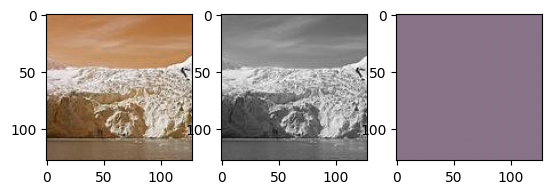

In [ ]:
rand_index = random.randint(0, 18000)

image_bw = gray_arr[rand_index]
image_c = color_arr[rand_index]

# Colorize the image
t = torch.from_numpy(np.moveaxis(image_bw, [2, 1], [0,2]))
colorized_image = autoencoder(t)
colorized_image_format = np.moveaxis(colorized_image.detach().numpy(), [1,2], [0,1])

plt.subplot(1,3,1)
plt.imshow(image_c)
plt.subplot(1,3,2)
plt.imshow(image_bw)
plt.subplot(1,3,3)
plt.imshow(colorized_image_format)
plt.show()

# LEFT TO RIGHT: ORIGINAL, GRAYSCALE, COLORIZED

# Visualize model

Using [pytorchviz](https://github.com/szagoruyko/pytorchviz)!

In [ ]:
!pip install torchviz

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached 

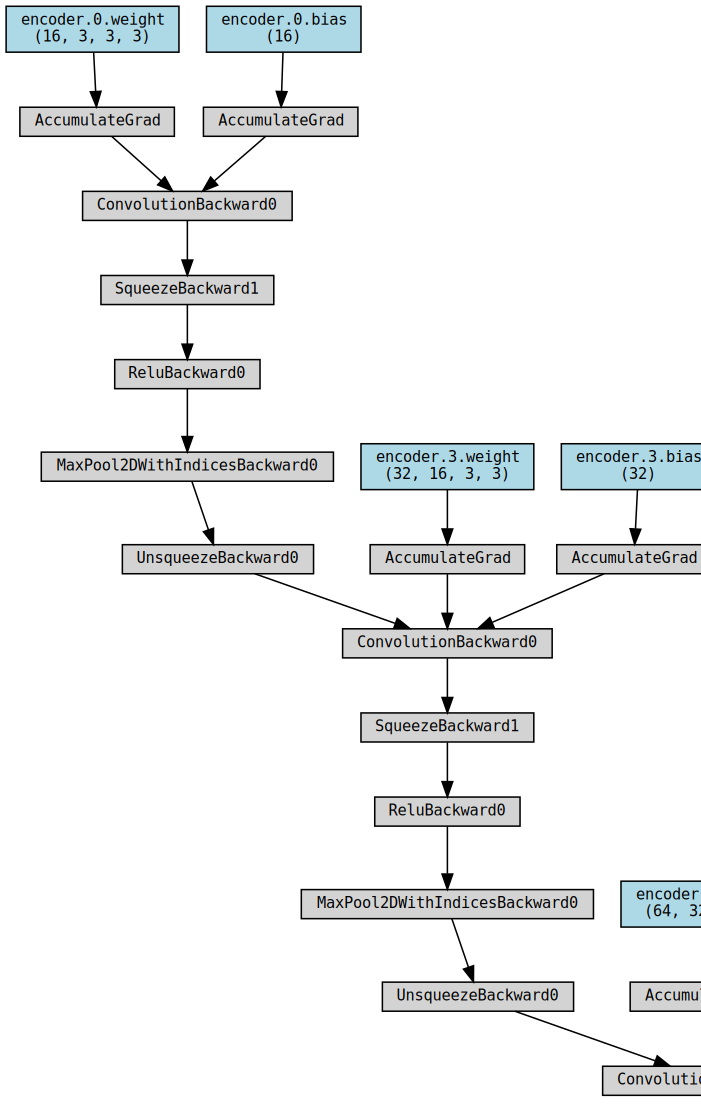

In [ ]:
from torchviz import make_dot
make_dot(colorized_image.mean(), params=dict(autoencoder.named_parameters()))

In [ ]:
torch.save(autoencoder.decoder,'/content/CPSC-440-Project/v0/decoder_weights')

In [ ]:
torch.save(autoencoder.encoder,'/content/CPSC-440-Project/v0/encoder_weights')

# Load model

In [ ]:
autoencoder.decoder = torch.load('/content/CPSC-440-Project/v0/decoder_weights')
autoencoder.encoder = torch.load('/content/CPSC-440-Project/v0/encoder_weights') # need some weights saved here!

# 4. Push changes

Look for any changes in the project directory, excluding this notebook, and push them.


In [ ]:
!git add .

In [ ]:
!git status

In [ ]:
!git commit -m "Message here"

In [ ]:
!git push

# 5. Save notebook

Commiting this notebook requires a special maneuver:

> File > Save a copy in github > enter original `path` + new commit msg

That's it!